In [1]:
# Importing required libraries
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
# Setting up default arguments for saving figures
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

# Set figure and Pandas display parameters
mpl.rc("savefig", dpi=300)
sc.set_figure_params(
    dpi_save=150,
    frameon=False,
    vector_friendly=True,
    fontsize=6,
    figsize=(3,3),
    format='pdf',
    transparent=True
)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Define style settings
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')

# Define file output configurations
output_dir = "../figures/MB_shared_GEX/"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create the directory if it does not exist
output_suffix = ""
output_formats = [".png", ".pdf"]

# Function to save figures with the given parameters
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    # Loop through each format and save the figure
    for output_format in output_formats:
        fig.savefig(f"{output_dir}/{name}{output_suffix}{output_format}", **savefig_args)
    return None


## Custom Functions

In [2]:
def plot_custom_dotplot(ad, markers):
    # dot plot creation
    dp = sc.pl.DotPlot(ad, markers, groupby= 'shared', figsize = (2, 2.25), vmax = 2, vmin = 0,  expression_cutoff = 0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

    # get axes for tweaking out
    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')
    # First, remove the current title
    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    # Then, create a new title using a text object
    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    # Get the bounding box of the main plot
    mainplot_box = axes['mainplot_ax'].get_position()
    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')
    ax = axes['mainplot_ax']
    return dp

### Load the Data

In [3]:
# configuration:
data_dir = "../../data/annotation"
h5ad = f'{data_dir}/all_sharing.h5ad.gz'
#h5ad = f'{data_dir}/TBd6_sharing.h5ad.gz'
tissue_combo = 'LN_SP'
# this is empty for now because I don't think they are useful for the dotplots atm
canonical_markers = []
# Dictionary to map tissue_combo to DataFrame columns
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

In [4]:
adata = sc.read_h5ad(h5ad)

In [5]:
# Subset to Memory B cells
mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
print(mb_adata.obs.shape, "Memory B cells to analyze")
print(asc_adata.obs.shape, "Memory B cells to analyze")
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

(89201, 20) Memory B cells to analyze
(26366, 20) Memory B cells to analyze


## Calculate DE genes between the groups

/tmp/ipykernel_179839/2692640101.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]


89201 cells
89201 cells after removing nans in shared

 LN_LN 
 mb_cells 






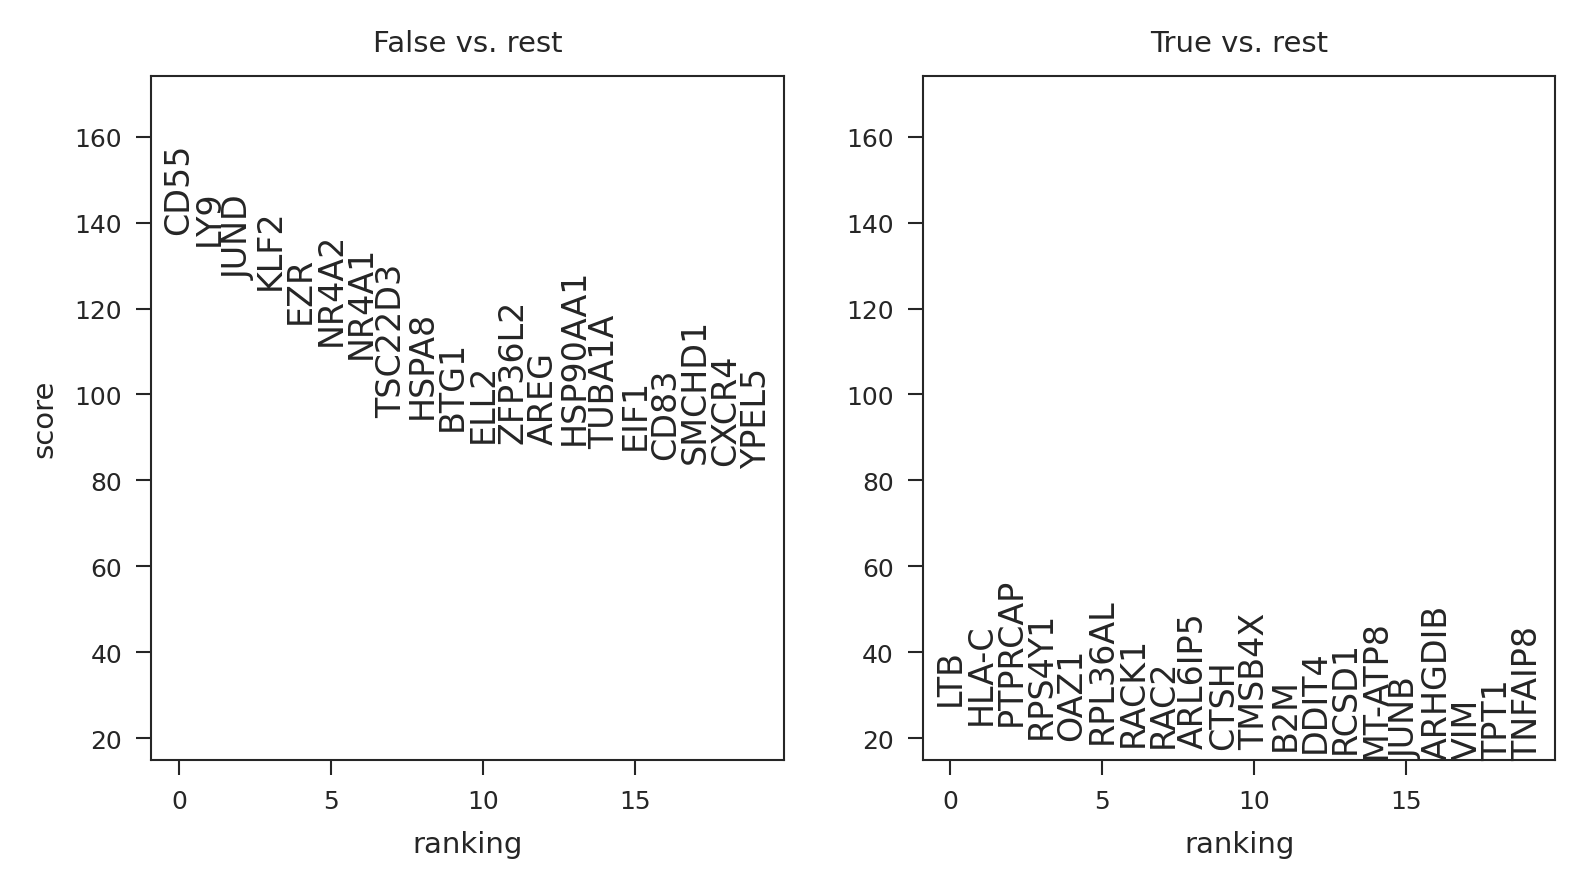

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


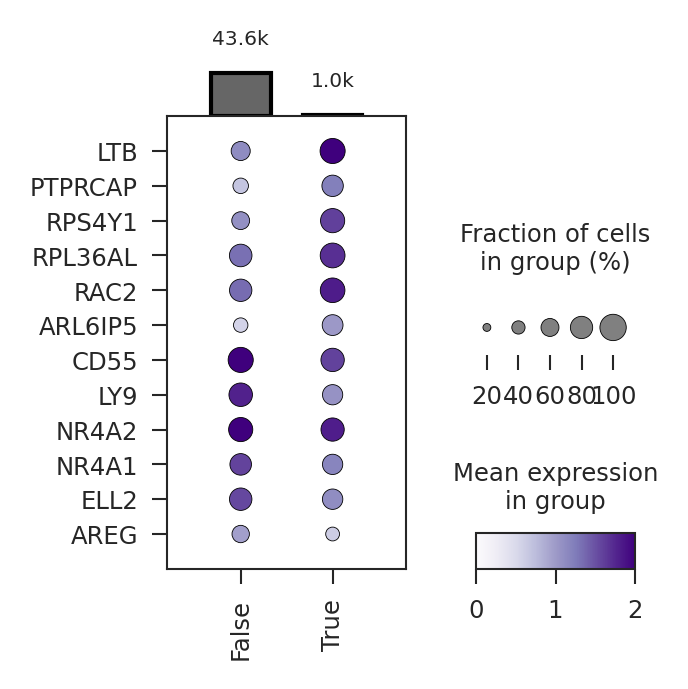

created ../../../data/annotation/LN_LN/mb_cells/
created ../figures/MB_shared_GEX/LN_LN/mb_cells/


/tmp/ipykernel_179839/2692640101.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]


26366 cells
26366 cells after removing nans in shared

 LN_LN 
 as_cells 






KeyboardInterrupt: 

In [6]:
use_filtered_genes = True
for tissue_combo in tissue_combo_to_column.keys():
    # Dictionary to hold AnnData objects and their descriptors
    adata_dict = {'all_data': adata, 'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}
    adata_dict = {'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}

    # Loop through the dictionary
    for descriptor, ad in adata_dict.items():        
        ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]
        # restrict to vdjs discovered in either tissue
        print(ad.shape[0], "cells")
        ad.obs['shared'] = ad.obs.shared.astype('category')
        #ad = ad[ad.obs.shared != 'nan']
        ad.obs.shared = ad.obs.shared.cat.remove_unused_categories()
        print(ad.shape[0], "cells after removing nans in shared")
        print("\n", tissue_combo, "\n", descriptor, "\n\n\n\n")
        # Perform ranking of genes
        method = 'wilcoxon'
        #key = f'shared_{method}'
        key = 'rank_genes_groups'
        sc.tl.rank_genes_groups(ad, groupby='shared', method=method, pts=True)
        sc.pl.rank_genes_groups(ad, key = key)
        sc.tl.filter_rank_genes_groups(ad,min_fold_change=0.5, min_in_group_fraction=0.15, max_out_group_fraction=0.8)
        # Plot ranked genes
        #sc.pl.rank_genes_groups(ad, key='rank_genes_groups_filtered')
        
        # Get the DataFrame of ranked genes
        dedf_True = sc.get.rank_genes_groups_df(ad, group="True", key=key)
        dedf_False = sc.get.rank_genes_groups_df(ad, group="False", key=key)
        dedf_filtered_true = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups_filtered')
        dedf_filtered_false = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups_filtered')
        # custom dotplot need doc
        if use_filtered_genes:
            true_markers = dedf_filtered_true.dropna(subset = 'names')['names'][:6].to_list()
            false_markers = dedf_filtered_false.dropna(subset = 'names')['names'][:6].to_list()
        else:
            true_markers = dedf_True['names'][:6].to_list()
            false_markers = dedf_False['names'][:6].to_list()
        markers = true_markers + false_markers
        try:
            dp = plot_custom_dotplot(ad, markers)
        except:
            print("Dot plot tried with", len(markers), "could be an issue")
            pass
        # Create a folder for tissue_combo if it doesn't exist
        folder_path = f"../../../data/annotation/{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)
        # Save dedf_filtered to a file within the tissue_combo folder using f-string for the full path
        dedf_True.to_csv(f"{folder_path}de_genes.tab", sep='\t')
        file_path = f"{folder_path}filtered_de_genes_true.tab"
        dedf_filtered_true.to_csv(file_path, sep = '\t')
        file_path = f"{folder_path}filtered_de_genes_false.tab"
        dedf_filtered_false.to_csv(file_path, sep = '\t')
        folder_path = f"{output_dir}{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)

In [ ]:
# covert probable boolean strings to actual booleans (due to writing strings issue with adata.write_h5ad())

ad.obs = convert_boolean_columns(ad.obs)
# create column for whether any memory B cell is shared between any of the tissue combos
# binarize
ad.obs['shared'] = ad.obs[f"shared_{tissue_relationship}"]
print(ad.obs.shared.value_counts().xs(True), "shared B cells")
print(ad.obs.shared.value_counts().xs(False), "not shared B cells")
# extract feature set from DEG analysis
use_filtered = False
if use_filtered:
    shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset='names').names[:30]
else:
    shared_genes = pd.read_table(gene_feature_sets[2], index_col=0).dropna(subset = 'names').names[:30]
non_shared_genes = pd.read_table(gene_feature_sets[1], index_col=0).dropna(subset = 'names')['names'].iloc[:15]


if include_non_shared:
    feature_genes = list(shared_genes) + list(non_shared_genes)
else:
    feature_genes = list(shared_genes)

NameError: name 'convert_boolean_columns' is not defined

In [ ]:
response_vars = list(tissue_combo_to_column.values())
# add non gene variables to the classifier
if use_meta:
    meta_vars = ['switched', 'v_mismatch', 'celltypist']
else:
    meta_vars = []

features = feature_genes +  meta_vars + response_vars
df = sc.get.obs_df(ad, keys = features)
df.to_csv(clf_data, sep = '\t')

Random Forest Accuracy: 0.6297169811320755
Random Forest Classification Report:               precision    recall  f1-score   support

       False       0.62      0.64      0.63       420
        True       0.64      0.62      0.63       428

    accuracy                           0.63       848
   macro avg       0.63      0.63      0.63       848
weighted avg       0.63      0.63      0.63       848

Logistic Regression Accuracy: 0.6332547169811321
Logistic Regression Classification Report:               precision    recall  f1-score   support

       False       0.62      0.65      0.64       420
        True       0.64      0.62      0.63       428

    accuracy                           0.63       848
   macro avg       0.63      0.63      0.63       848
weighted avg       0.63      0.63      0.63       848



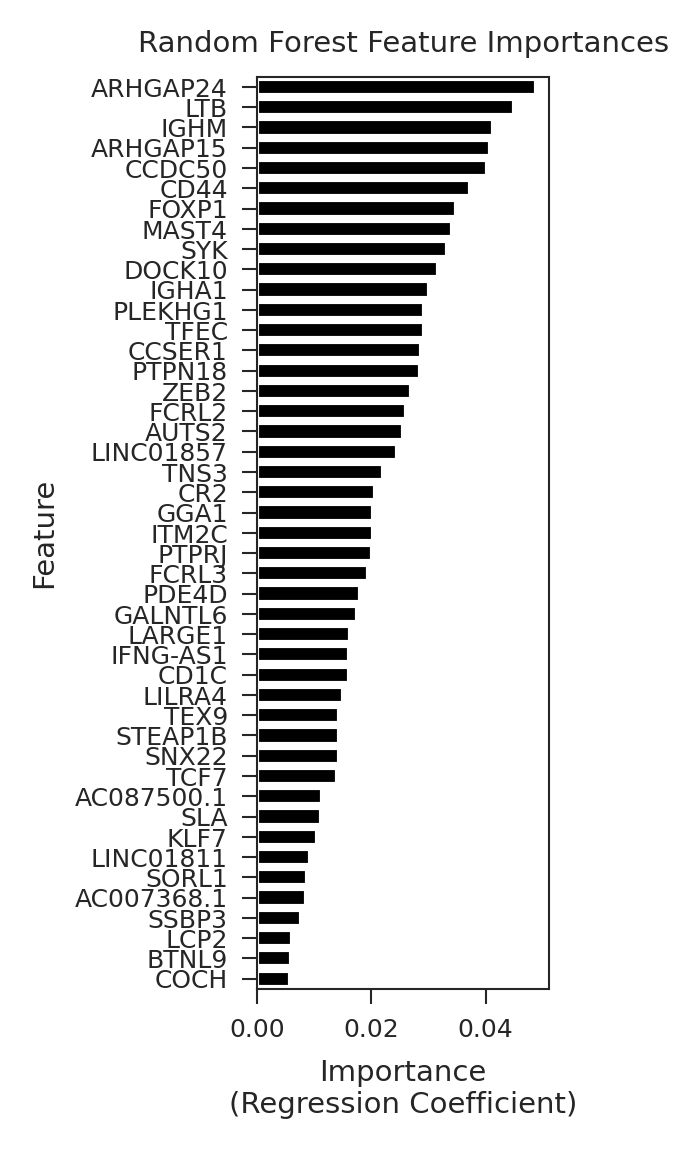

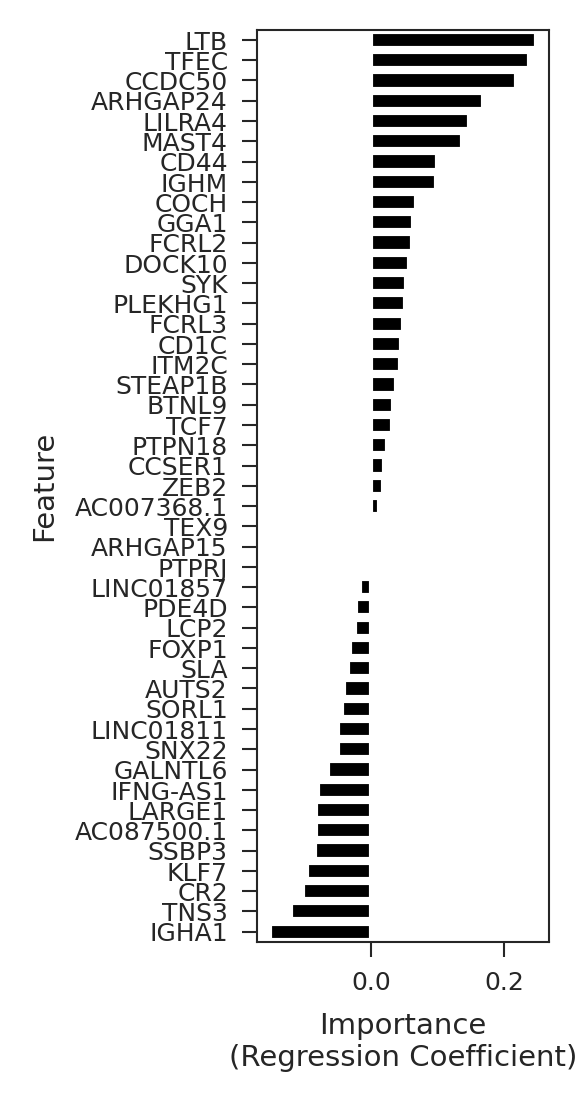

In [ ]:
# Load the dataset
df = pd.read_table(clf_data)

# set 'shared' column according to logic
shared_column = f"shared_{tissue_relationship}"
df['shared'] = df[shared_column]
# remove other sharing columns
for val in tissue_combo_to_column.values():
    df.pop(val)

# Drop rows with NaN values in the 'shared' column
df.dropna(subset=['shared'], inplace=True)

# Convert the 'shared' column to integers
df['shared'] = df['shared'].astype(bool)

# Drop index column
df = df.drop(columns=['cb_suid'])

if use_meta:
    # remove celltypist column:
    df.pop('celltypist')
# Label encode 'switched'
    label_encoder = LabelEncoder()
    df['switched'] = label_encoder.fit_transform(df['switched'])

# Count the number of occurrences of each class
class_counts = df['shared'].value_counts()

# Identify the majority and minority classes
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate the data by class
df_majority = df[df['shared'] == majority_class]
df_minority = df[df['shared'] == minority_class]

# Undersample the majority class
df_majority_undersampled = df_majority.sample(len(df_minority))

# Concatenate the majority-undersampled and minority dataframes
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame
df_undersampled = df_undersampled.sample(frac=1).reset_index(drop=True)

# Split the dataset into features (X) and target variable (y)
X = df_undersampled.drop('shared', axis=1)
y = df_undersampled['shared']

# Scale the features for clustering and logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Evaluate Random Forest
rf_y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_rep = classification_report(y_test, rf_y_pred)

# Feature importances for Random Forest
rf_feature_importances = rf_clf.feature_importances_

# Initialize and train Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Evaluate Logistic Regression
log_y_pred = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
log_classification_rep = classification_report(y_test, log_y_pred)

# Feature importances for Logistic Regression (coefficients)
log_feature_importances = log_reg.coef_[0]

# Plot feature importances
fig1 = plot_feature_importances(rf_feature_importances, X.columns, 'Random Forest Feature Importances')
fig2 = plot_feature_importances(log_feature_importances, X.columns, '')
save_figure(fig2, "LogisticRegression_Feature_Importance")

# Plot Decision Scores

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


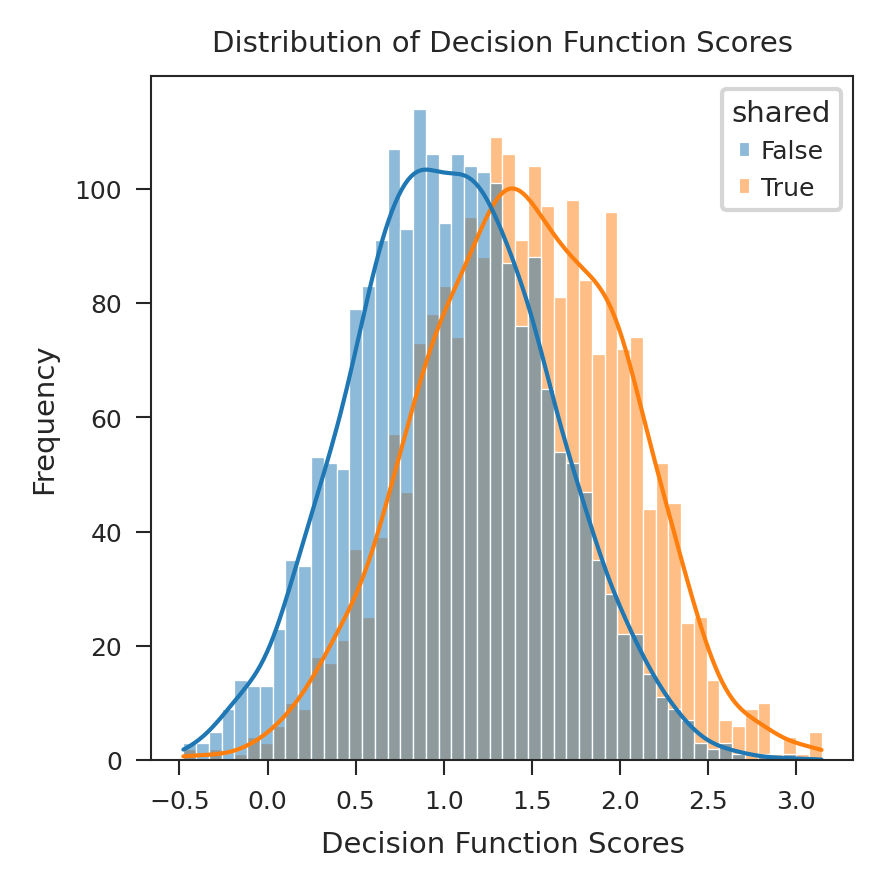

In [ ]:
decision_scores = log_reg.decision_function(X)
plt_df = pd.DataFrame(decision_scores, columns=['lr_score'])
plt_df['shared'] = y

log_probs = log_reg.predict_log_proba(X)
probs = np.exp(log_probs)/(1 + np.exp(log_probs))
probs = probs.T[1]/(probs.T[0]+probs.T[1])
sns.histplot(plt_df, x = plt_df['lr_score'], bins=50, kde=True, hue='shared')
plt.xlabel('Decision Function Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Decision Function Scores')
plt.show()

In [ ]:
# read clf_data
df = pd.read_table(clf_data)
df = df.set_index('cb_suid')

X_index = len(tissue_combo_to_column) + len(meta_vars)
X = df.iloc[:,:-X_index].values
# calculate decision scores for all Memory Cells
# this will break in the include meta_vars case
decision_scores = log_reg.decision_function(X)
df['decision_scores'] = decision_scores
#df.to_csv("data.csv")

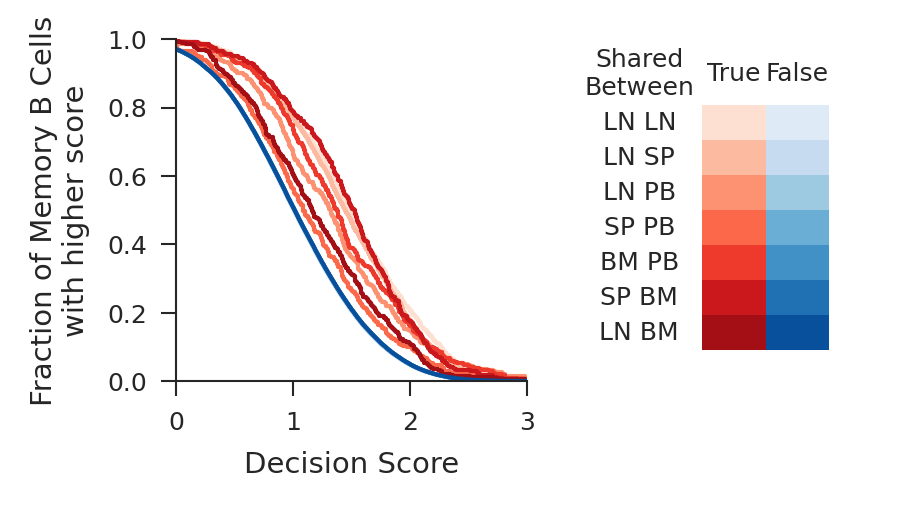

In [ ]:


# Set up a gridspec layout for the figure
fig = plt.figure(figsize=(3, 1.5))  # Adjust the overall figure size as needed
gs = gridspec.GridSpec(1, 2)  # Adjust the ratio to fit the plot and the table

# Create the ECDF plot on the first part of the grid
ax = plt.subplot(gs[0])

# Handle NaN values by setting them to False
df.fillna({col: False for col in df.filter(like='shared_').columns}, inplace=True)

# Define the tissue_combo_to_column dictionary for renaming legend labels
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    'SP_PB' : 'shared_SP_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_BM" : 'shared_SP_BM',
    "LN_BM" : 'shared_LN_BM'
    # Add more mappings as needed
}

# Initialize empty dictionary to store color mapping
color_mapping = {}

# Define shades of red and blue for True and False values
shades_of_red = sns.color_palette("Reds", n_colors=len(df.filter(like='shared_').columns))
shades_of_blue = sns.color_palette("Blues", n_colors=len(df.filter(like='shared_').columns))


# Loop over each tissue_combo (shared column) to plot
for idx, tissue_combo in enumerate(df.filter(like='shared_').columns):
    # Extract human-readable label from the dictionary if available
    human_readable_label = [k for k, v in tissue_combo_to_column.items() if v == tissue_combo]
    human_readable_label = human_readable_label[0] if human_readable_label else tissue_combo
    
    # Extract data for the current tissue_combo where the value is True
    tissue_df = df[df[tissue_combo]]
    
    # Plot the ECDF for True values in this tissue_combo
    sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                 color=shades_of_red[idx], label=f"{human_readable_label} True")
    
    # Extract data for the current tissue_combo where the value is False
    tissue_df = df[~df[tissue_combo]]
    
    # Plot the ECDF for False values in this tissue_combo
    sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                 color=shades_of_blue[idx], label=f"{human_readable_label} False")
# Add legend to the plot
#ax.legend(title='Tissue Combo', bbox_to_anchor=(1, 1.2), loc='upper left')
ax.set_xlabel("Decision Score")
#ax.set_yscale("log")

ax.set_ylabel("Fraction of Memory B Cells\nwith higher score")
ax.set_xlim(0,3)

sns.despine()
# Create the table in the second part of the grid
ax_table = plt.subplot(gs[1])
ax_table.axis('off')  # Hide the axis

# Generate the table content
table_colors = [[shades_of_red[i], shades_of_blue[i]] for i in range(len(shades_of_red))]
cell_text = [[key.replace('_', ' ')] + ['' for _ in range(2)] for key in tissue_combo_to_column.keys()]
col_labels = ["Shared\nBetween\n", "True\n", "False\n"]
# Adjust the width of the first column (Tissue Pair) to move the text to the left
colWidths = [0.6, 0.3, 0.3]  # Sum should be 1.0; adjust as needed for your layout

# Create the table with the correct cell colors
table = ax_table.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', colWidths=colWidths)
for i, (tissue_pair, colors) in enumerate(zip(tissue_combo_to_column.keys(), table_colors)):
    table[(i+1, 0)].set_facecolor('none')  # Tissue pair column doesn't get a color
    table[(i+1, 1)].set_facecolor(colors[0])  # True column
    table[(i+1, 1)].set_text_props(color='w')  # Set text color to white for visibility
    table[(i+1, 2)].set_facecolor(colors[1])  # False column
    table[(i+1, 2)].set_text_props(color='w')  # Set text color to white for visibility

# Remove the bounding box of the table
for key, cell in table.get_celld().items():
    cell.set_edgecolor('none')

# Set the font size for the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(0.6, 0.7)

plt.subplots_adjust(wspace=0)  # Adjust the width space as needed
save_figure(fig, "ecdf_logreg_scores")

## By Donor

/tmp/ipykernel_153515/952105884.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'donor'] = df.donor.map(adata.obs.donor)


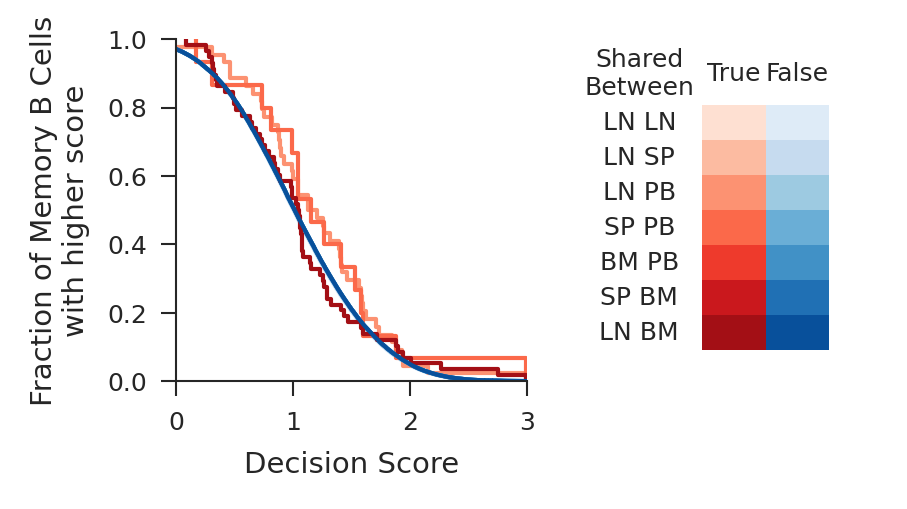

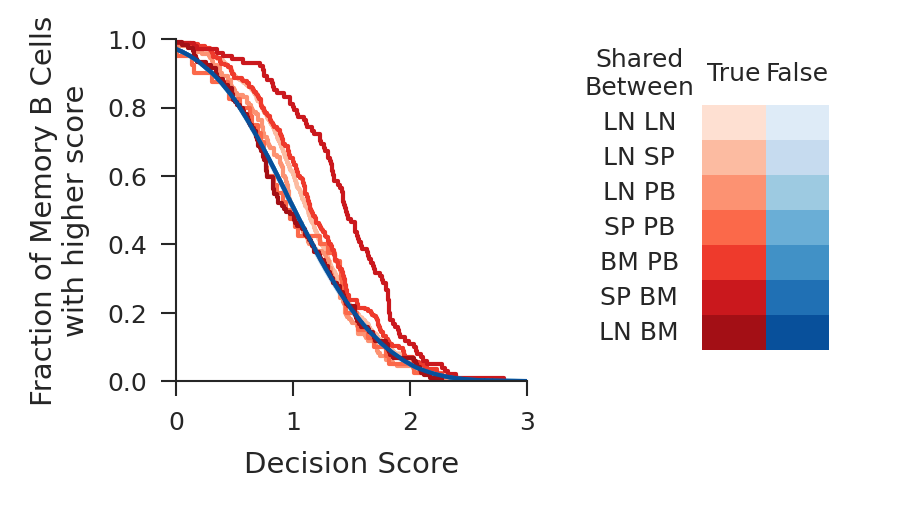

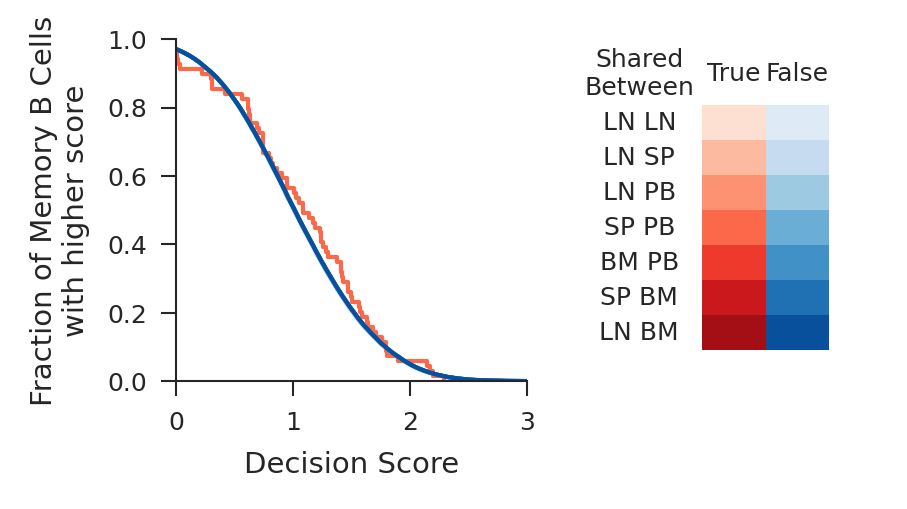

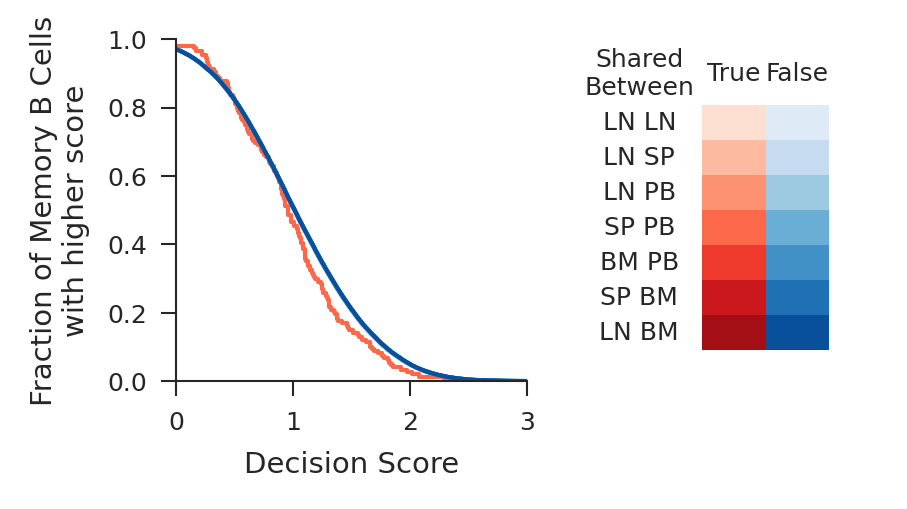

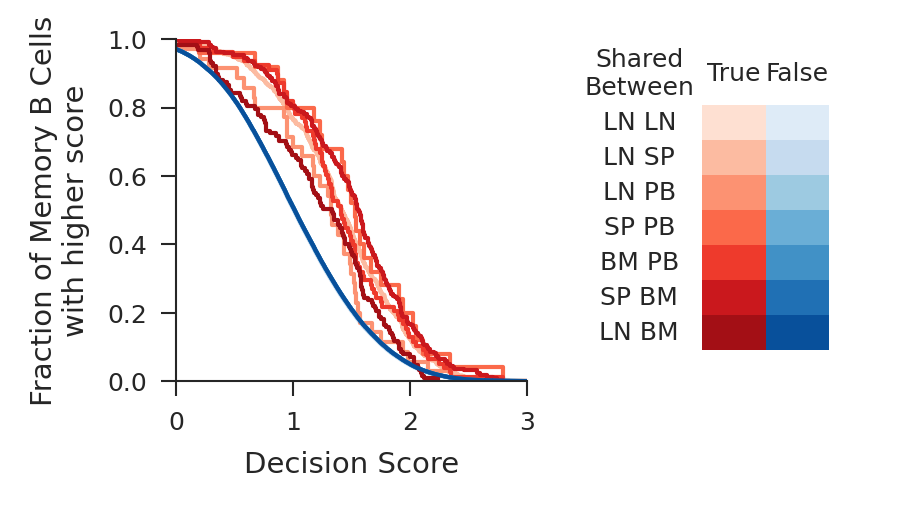

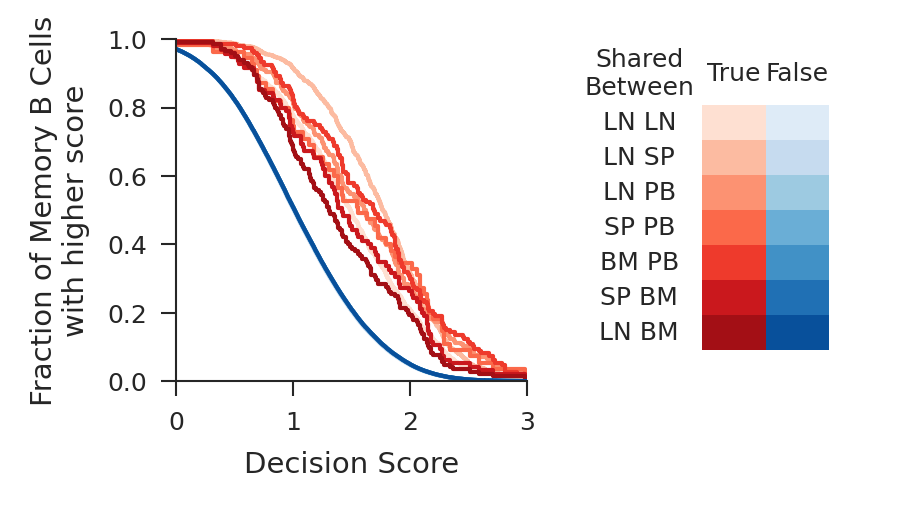

In [ ]:
df.loc[:,'donor'] = df.index.values
df.loc[:, 'donor'] = df.donor.map(adata.obs.donor)

for donor, _df in df.groupby("donor"):
    print()
    # Set up a gridspec layout for the figure
    fig = plt.figure(figsize=(3, 1.5))  # Adjust the overall figure size as needed
    gs = gridspec.GridSpec(1, 2)  # Adjust the ratio to fit the plot and the table

    # Create the ECDF plot on the first part of the grid
    ax = plt.subplot(gs[0])

    # Handle NaN values by setting them to False
    _df.fillna({col: False for col in _df.filter(like='shared_').columns}, inplace=True)

    # Define the tissue_combo_to_column dictionary for renaming legend labels
    tissue_combo_to_column = {
        'LN_LN': 'shared_LN_LN',
        'LN_SP': 'shared_LN_SP',
        'LN_PB': 'shared_LN_PB',
        'SP_PB' : 'shared_SP_PB',
        "BM_PB": 'shared_BM_PB',
        "SP_BM" : 'shared_SP_BM',
        "LN_BM" : 'shared_LN_BM'
        # Add more mappings as needed
    }

    # Initialize empty dictionary to store color mapping
    color_mapping = {}

    # Define shades of red and blue for True and False values
    shades_of_red = sns.color_palette("Reds", n_colors=len(_df.filter(like='shared_').columns))
    shades_of_blue = sns.color_palette("Blues", n_colors=len(_df.filter(like='shared_').columns))


    # Loop over each tissue_combo (shared column) to plot
    for idx, tissue_combo in enumerate(_df.filter(like='shared_').columns):
        # Extract human-readable label from the dictionary if available
        human_readable_label = [k for k, v in tissue_combo_to_column.items() if v == tissue_combo]
        human_readable_label = human_readable_label[0] if human_readable_label else tissue_combo
        
        # Extract data for the current tissue_combo where the value is True
        tissue_df = _df[_df[tissue_combo]]
        
        # Plot the ECDF for True values in this tissue_combo
        sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                    color=shades_of_red[idx], label=f"{human_readable_label} True")
        
        # Extract data for the current tissue_combo where the value is False
        tissue_df = df[~df[tissue_combo]]
        
        # Plot the ECDF for False values in this tissue_combo
        sns.ecdfplot(data=tissue_df, x='decision_scores', complementary=True, 
                    color=shades_of_blue[idx], label=f"{human_readable_label} False")
    # Add legend to the plot
    #ax.legend(title='Tissue Combo', bbox_to_anchor=(1, 1.2), loc='upper left')
    ax.set_xlabel("Decision Score")
    #ax.set_yscale("log")

    ax.set_ylabel("Fraction of Memory B Cells\nwith higher score")
    ax.set_xlim(0,3)

    sns.despine()
    # Create the table in the second part of the grid
    ax_table = plt.subplot(gs[1])
    ax_table.axis('off')  # Hide the axis

    # Generate the table content
    table_colors = [[shades_of_red[i], shades_of_blue[i]] for i in range(len(shades_of_red))]
    cell_text = [[key.replace('_', ' ')] + ['' for _ in range(2)] for key in tissue_combo_to_column.keys()]
    col_labels = ["Shared\nBetween\n", "True\n", "False\n"]
    # Adjust the width of the first column (Tissue Pair) to move the text to the left
    colWidths = [0.6, 0.3, 0.3]  # Sum should be 1.0; adjust as needed for your layout

    # Create the table with the correct cell colors
    table = ax_table.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', colWidths=colWidths)
    for i, (tissue_pair, colors) in enumerate(zip(tissue_combo_to_column.keys(), table_colors)):
        table[(i+1, 0)].set_facecolor('none')  # Tissue pair column doesn't get a color
        table[(i+1, 1)].set_facecolor(colors[0])  # True column
        table[(i+1, 1)].set_text_props(color='w')  # Set text color to white for visibility
        table[(i+1, 2)].set_facecolor(colors[1])  # False column
        table[(i+1, 2)].set_text_props(color='w')  # Set text color to white for visibility

    # Remove the bounding box of the table
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('none')

    # Set the font size for the table
    table.auto_set_font_size(False)
    table.set_fontsize(6)
    table.scale(0.6, 0.7)

    plt.subplots_adjust(wspace=0)  # Adjust the width space as needed
    save_figure(fig, f"ecdf_logreg_scores_{donor}")